In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cn
from tqdm import tqdm
import pyfilon as fil
from joblib import Parallel, delayed

In [2]:
def transverse_resonator(f: float, fr: float, Rperp: float, Q:float, beta:float) -> complex:
    '''
    Ideal transverse resonator impedance as described by Chao's Equation 2.87, HOWEVER
    Rperp != Rs as defined by Chao. Rperp = v/omega_r * Rs. Rperp has units of Ohm/m
    whilst Rs as defined by Chao has units of Ohm/m^2.
    '''
    w = 2*np.pi*f
    wr = 2 * np.pi*fr
    Rs = Rperp * wr/cn.c/beta
    return cn.c*beta/w * Rs/(1+1j*Q*(wr/w - w/wr))

def wake_transverse_resonator(z, fr, Rperp, Q, beta):
    omega_r = 2*np.pi*fr
    alpha = omega_r/2/Q
    omegabar = np.sqrt(omega_r**2 - alpha**2)
    heaviside = (-(np.sign(z)-1)/2)  # = +1 if z <0, = 0 if z > 0
    return heaviside * Rperp * omega_r**2/Q/omegabar * np.exp(alpha*z/beta/cn.c) * np.sin(omegabar * z/beta/cn.c)

In [3]:
freqs = np.logspace(-3, 10, 5000)
z = -np.logspace(-4, 5, 500)

In [4]:
# For convenience, define some vectorised versions of these
# functions so that I can evaluate the wake at several values of
# z simultaneously
filon_sin = np.vectorize(fil.filon_fun_sin,
                         excluded=(0, 1, 2, 4))
filon_cos = np.vectorize(fil.filon_fun_cos,
                         excluded=(0, 1, 2, 4))

# Define the limits for the integration
# lower limits start at (nearly) 0 then take every value of frequency except the last value.
# upper limit takes every value of frequency including the final value.
# multiplied by 2pi because these are limited for omega, not f
aa = np.append([1e-3], freqs[:-1]) * 2 * np.pi
bb = freqs * 2 * np.pi

In [5]:
beta = 1
num = 3

def wrapper(aa, bb):
    # aa, bb = limits
    F1 = filon_sin(lambda w: np.real(transverse_resonator(w/2/np.pi, 83e3, 1e6, 3, 1)), aa, bb, z / beta / cn.c, num)
    F2 = filon_cos(lambda w: np.imag(transverse_resonator(w/2/np.pi, 83e3, 1e6, 3, 1)), aa, bb, z / beta / cn.c, num)
    return np.real(1 / np.pi * (F1 + F2))

In [6]:
_wake = np.array(Parallel(n_jobs=8)(delayed(wrapper)(i, j)
                                      for (i, j) in tqdm(zip(aa, bb), total=len(freqs)-1)))
wake = np.sum(_wake, axis=0)
del(_wake)

5000it [00:06, 806.75it/s]                          


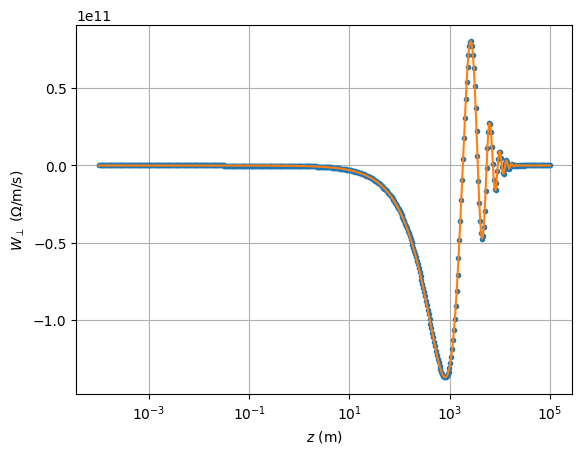

In [7]:
plt.figure()
plt.plot(-z, wake, '.')
plt.plot(-z, wake_transverse_resonator(z, 83e3, 1e6, 3, 1))

plt.xscale('log')
plt.grid()
plt.xlabel(r"$z$ (m)")
plt.ylabel(r"$W_{\perp}$ ($\Omega$/m/s)") 
plt.show()

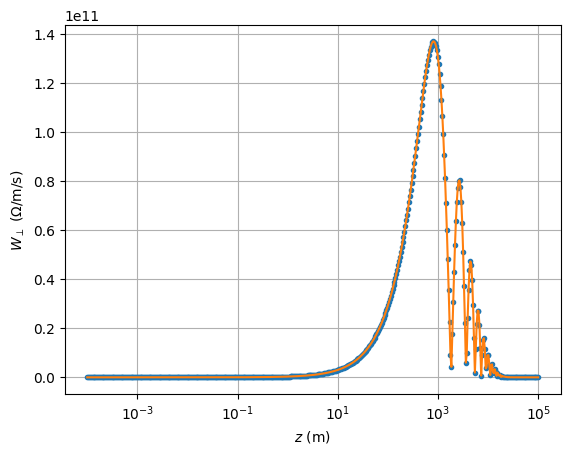

In [8]:
plt.figure()
plt.plot(-z, np.abs(wake), '.')
plt.plot(-z, np.abs(wake_transverse_resonator(z, 83e3, 1e6, 3, 1)))

plt.xscale('log')
# plt.yscale('log')
plt.grid()
plt.xlabel(r"$z$ (m)")
plt.ylabel(r"$W_{\perp}$ ($\Omega$/m/s)") 
plt.show()

In [9]:
beta = 1

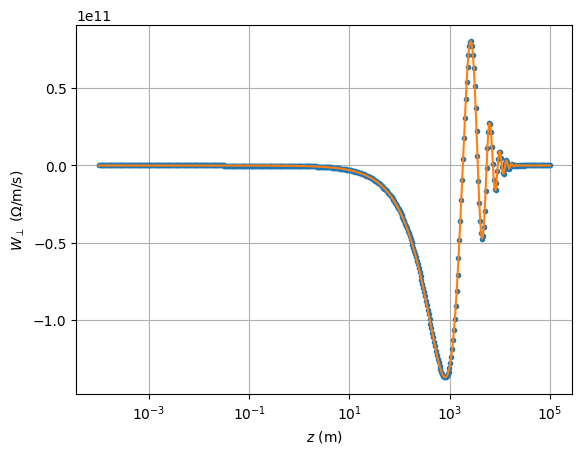

In [10]:
plt.figure()
plt.plot(-z, wake, '.')
plt.plot(-z, wake_transverse_resonator(z, 83e3, 1e6, 3, 1))

plt.xscale('log')
plt.grid()
plt.xlabel(r"$z$ (m)")
plt.ylabel(r"$W_{\perp}$ ($\Omega$/m/s)") 
plt.show()